In [ ]:
pip install tensorflow

In [1]:
pip install opendatasets

# CNN Cancer Detection Mini Project

In [2]:
#importing the necessary libraries
import opendatasets as od #to import Kaggle dataset, also need Kaggle API

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from random import sample
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam

## 1 Brief description of the problem and data

This project has dual functionality: it serves as the week 3 project for DTSA 5511 at CU Boulder, as well as a submission for the Kaggle Histopathologic Cancer Detection contest, https://www.kaggle.com/c/histopathologic-cancer-detection/overview.$^{1}$ The dataset being used by Kaggle is a subset of a larger dataset, PatchCamelyon (PCam) which can be found in its entirety on GitHub, https://github.com/basveeling/pcam. The subset being used in this project was precleaned by Kaggle to remove duplicate images.

Each object in this dataset represents one 96 x 96 pixel image is a scan of a lymph node. According to the Bas Veeling, the owner of the GitHub repository where PCam may be found, a label value of one "indicates that the center 32x32 pixel region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image."$^{2}$

We will begin by loading the data. When using this notebook on your local machine, you will also need to use the opendatasets library and code cells below to import the datasets from Kaggle. To do so, please have your API key from Kaggle ready.

In [3]:
#importing all of the datasets straight from Kaggle
od.download("https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=train")

Skipping, found downloaded files in "./histopathologic-cancer-detection" (use force=True to force download)


In [4]:
train = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

## 2 Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Let's take a minute to look at the data,

In [5]:
print('Head of Training Set Data File:')
print(train.head())
print('')
print('Training Set Data Null Values:')
print(train.isna().sum())
print('')
print('Training Set Data Unique Values:')
print(train.nunique())

Head of Training Set Data File:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Training Set Data Null Values:
id       0
label    0
dtype: int64

Training Set Data Unique Values:
id       220025
label         2
dtype: int64


Clearly, there are two labels being used here: 1 means that a tumor was detected and 0 means that the image is cancer free. The unique ids and number of training images confirms that there are 220,025 images in this training set without empty images, null values or duplicates.

To understand exactly what these images look like, here is a small sample:

In [6]:
#creating 'folders' for the images
folder_train = "histopathologic-cancer-detection/train/"
folder_test = "histopathologic-cancer-detection/test/"

print("Number of training images: {}".format(len(os.listdir(folder_train))))
print("Number of test images: {}".format(len(os.listdir(folder_test))))

Number of training images: 220025
Number of test images: 57458


In [7]:
# load the images
img_train = os.listdir(folder_train)
img_test = os.listdir(folder_test)

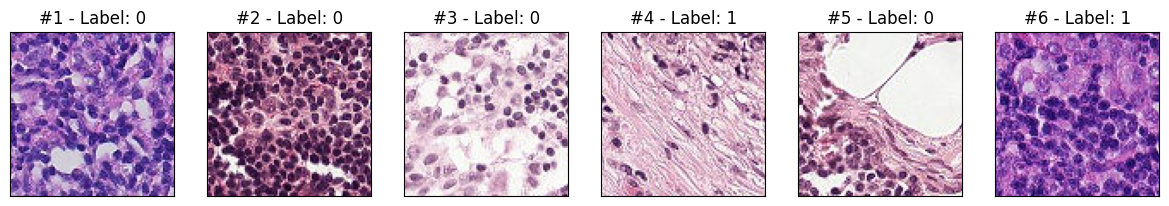

In [8]:
# sample of what the images look like
fig = plt.figure(figsize=(25, 4))
for i in range(6):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(folder_train + img_train[i])
    plt.imshow(im)
    label = train.loc[train['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

Since the dataset has all unique values, none of which are null, we do not need to remove any rows. To understand that number of cancer images vs those without, let's look at the distributions of the two labels within the training set.

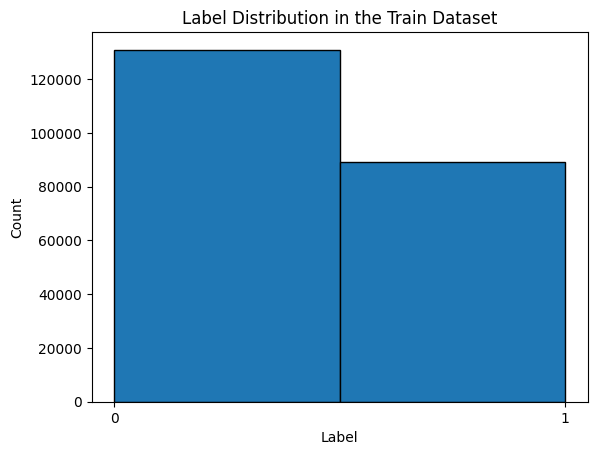

In [9]:
counts, bins = np.histogram(train['label'])
plt.hist(train['label'], bins =2, edgecolor='black')
plt.xticks(ticks = [0,1])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in the Train Dataset')
plt.show()

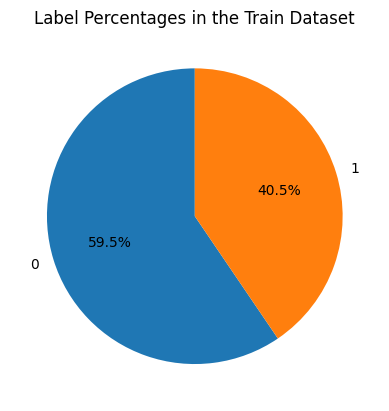

In [10]:
train_category = train.groupby(by='label').size()
plt.pie(train_category, labels=train_category.index, autopct='%1.1f%%', startangle=90)
plt.title('Label Percentages in the Train Dataset')
plt.show()

This dataset has about 130,000 cancer free images and approximately 90,000 with cancer. Even though this isn't an even split, there is a substantial amount in both categories to train a model.

## 3 Model Architecture

Let's start with a simple model, a fully connected neural network,

In [12]:
dense_model = Sequential()
dense_model.add(Flatten(input_shape=(96, 96, 3)))
dense_model.add(Dense(128, activation="relu"))
dense_model.add(Dense(1, activation="sigmoid"))

dense_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 128)               3539072   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3539201 (13.50 MB)
Trainable params: 3539201 (13.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We see that this model has just over three and a half million parameters which take up 13.5 MB. This is a HUGE model and would require a ton of resources to work with a training dataset of 220,025 images.

To find something that requires less memory, let's begin with a basic CNN model similar to the one described in this week's lecture: we will create two different convolution layers, the first with 16 3x3 filters and the second with 32 3x3 filters and use the ReLu activiation function for each layer. Each convolution layer will be followed by a 2x2 max pooling layer. Finally, the data will be flattened before running through the classifer section: another ReLu activation layer, followed by the sigmoid function. Since the description of the PCam images declared that any present tumor cells are located in the middle of the image, this author has decided not to include padding in any CNN models.

Before we create the model, let's define a mini-batch sample from the training data to run our different CNN models on to see how they fit.$^{3}$

In [14]:
BATCH_SIZE = 256
RANDOM_STATE = 34
images_train = train
images_train['label'] = images_train['label'].astype(str)
images_train['id'] = train['id'] + '.tif'
# Define the train and validation data split
train, valid = train_test_split(train, test_size=0.2)

# Define the data generators
train_datagen =  ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

test_datagen =  ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

# Set up the data generators with GPU support
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=folder_train,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=train,
    directory=folder_train,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))


Found 149617 validated image filenames belonging to 2 classes.
Found 26403 validated image filenames belonging to 2 classes.


In [19]:
ROC_1 = tf.keras.metrics.AUC()

# Define the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', ROC_1])

# Build the model
model.build(input_shape=(BATCH_SIZE, 64, 64, 3))

# Display the model summary
model.summary()

# Train the model

hist = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (256, 31, 31, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (256, 29, 29, 32)         4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (256, 14, 14, 32)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (256, 6272)               0         
                                                                 
 dense_6 (Dense)             (256, 256)               

Has you can see from the summary table above, we have cut the memory requirement by more than a half by going to a CNN model instead of the fully connected neural network. The number of parameters was reduced by nearly 2 million, to 1.6 million parameters. This is a remarkable savings, both in terms of memory and number of parameters.


## 4 Results and Analysis


Plotting the accuracy of each epoch using both the training subset and the test set, we obtain the graph below.

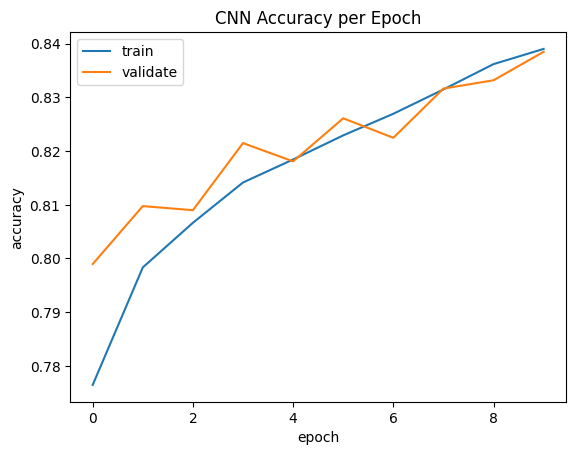

In [21]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('CNN Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

For both training and test data, the CNN model grows in accuracy for each epoch. Due to execution time, the choice was made to keep the number of epochs to 10. This CNN model appears to do a fairly good job as seen by the closeness of the training and test accuracy lines.

Now that we have fit a CNN model, let's see how changing the CNN model slightly yields different results.

Let's begin keeping all the layers the same except doubling the number of 3x3 filters in both convolution layers. The first layer will change from 16 to 32 filters and the second from 32 to 64 filters:

In [23]:
# Define the model
conv_model_64 = Sequential()
conv_model_64.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
conv_model_64.add(MaxPool2D(pool_size=(2, 2)))
conv_model_64.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
conv_model_64.add(MaxPool2D(pool_size=(2, 2)))
conv_model_64.add(Flatten())
conv_model_64.add(Dense(units=256, activation='relu'))
conv_model_64.add(Dense(units=1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.0001)
conv_model_64.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', ROC_1])

# Build the model
conv_model_64.build(input_shape=(BATCH_SIZE, 64, 64, 3))

# Display the model summary
conv_model_64.summary()

# Train your model

hist2 = conv_model_64.fit(train_generator, validation_data=valid_generator, epochs=10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (256, 62, 62, 32)         896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (256, 31, 31, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (256, 29, 29, 64)         18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (256, 14, 14, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (256, 12544)              0         
                                                                 
 dense_10 (Dense)            (256, 256)               

Not surprisingly, doubling the number of filters in both convolution layers doubles the number of overall parameters in the model as well as the memory needed. It also doubled the runtime to execute this code.

Let's take a look at how doubling the number of filters affected accuracy,

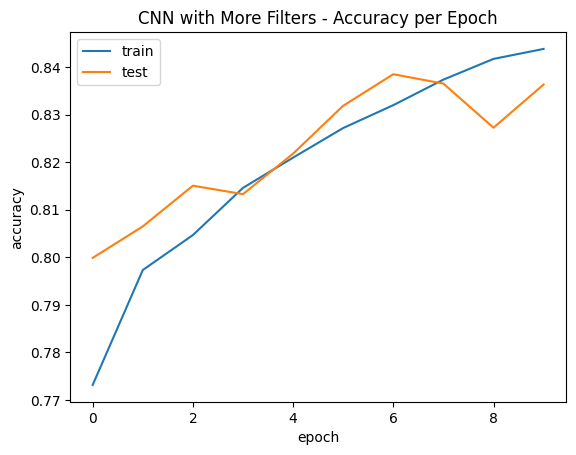

In [24]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('CNN with More Filters - Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

Comparing this graph to the first CNN model,

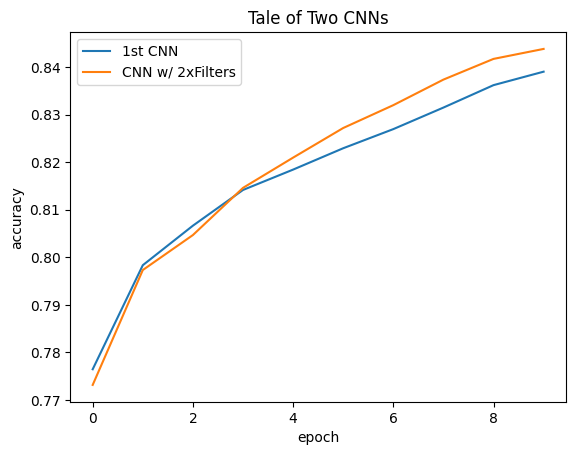

In [25]:
plt.plot(hist.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.title('Tale of Two CNNs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['1st CNN', 'CNN w/ 2xFilters'], loc='upper left')
plt.show();

Doubling the number of filters for each convolution layer, doubled the runtime with marginal gains in accuracy. Clearly, this is not a worthwhile trade-off.

Next, let's go back to the original filter numbers, but now we will add a dropout layer after each max-pooling to see what type of affect that has on our model:

In [26]:
# Define the model
conv_dropout_model = Sequential()
conv_dropout_model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
conv_dropout_model.add(MaxPool2D(pool_size=(2, 2)))
conv_dropout_model.add(Dropout(0.5))
conv_dropout_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
conv_dropout_model.add(MaxPool2D(pool_size=(2, 2)))
conv_dropout_model.add(Dropout(0.5))
conv_dropout_model.add(Flatten())
conv_dropout_model.add(Dense(units=256, activation='relu'))
conv_dropout_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.0001)
conv_dropout_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', ROC_1])

# Build the model
conv_dropout_model.build(input_shape=(BATCH_SIZE, 64, 64, 3))

# Display the model summary
conv_dropout_model.summary()

# Train your model

hist3 = conv_dropout_model.fit(train_generator, validation_data=valid_generator, epochs=10)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (256, 62, 62, 16)         448       
                                                                 
 max_pooling2d_10 (MaxPooli  (256, 31, 31, 16)         0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (256, 31, 31, 16)         0         
                                                                 
 conv2d_13 (Conv2D)          (256, 29, 29, 32)         4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (256, 14, 14, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_1 (Dropout)         (256, 14, 14, 32)        

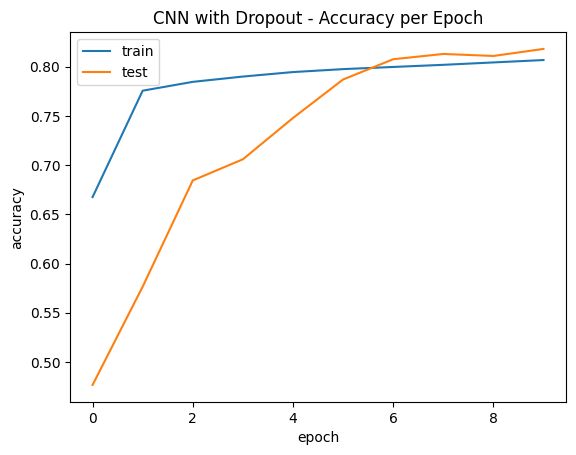

In [27]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('CNN with Dropout - Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

The CNN with Dropout model shows a very fast improvement in accuracy; however, it is still a worse performer than the other two as seen below:

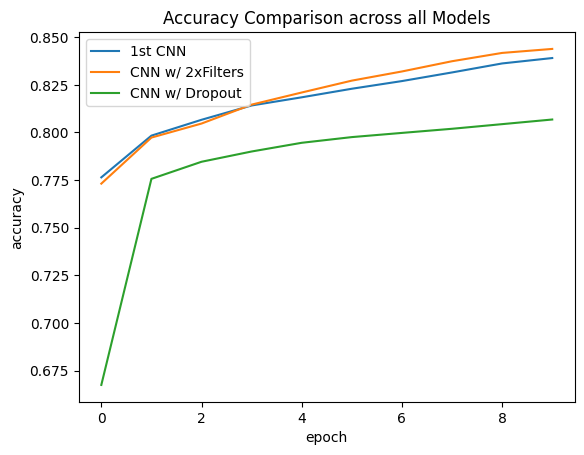

In [28]:
plt.plot(hist.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.plot(hist3.history['accuracy'])
plt.title('Accuracy Comparison across all Models')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['1st CNN', 'CNN w/ 2xFilters', 'CNN w/ Dropout'], loc='upper left')
plt.show();

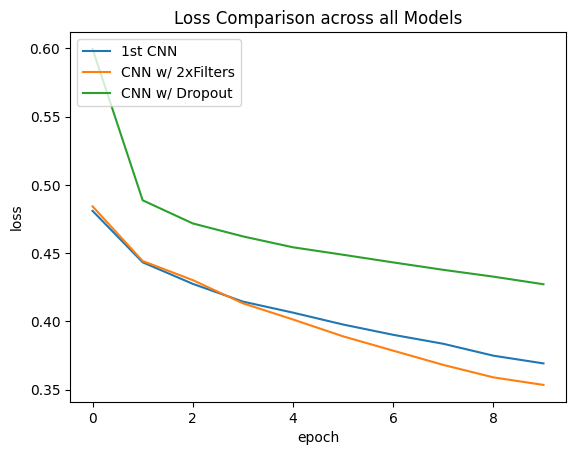

In [29]:
plt.plot(hist.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist3.history['loss'])
plt.title('Loss Comparison across all Models')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1st CNN', 'CNN w/ 2xFilters', 'CNN w/ Dropout'], loc='upper left')
plt.show();

All three models improved in loss over the epochs. Again the CNN model with the most filters is the best, but at the cost of double the runtime.

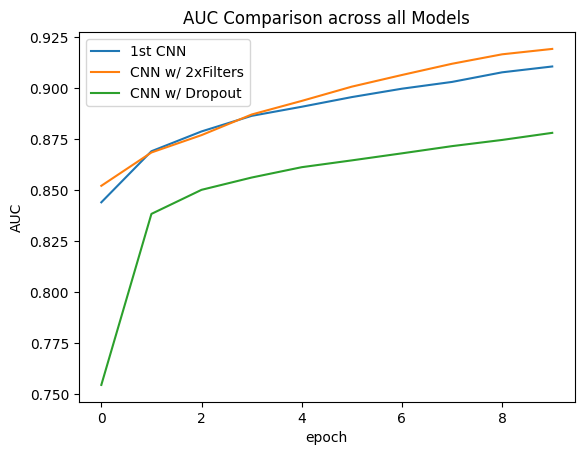

In [30]:
plt.plot(hist.history['auc_1'])
plt.plot(hist2.history['auc_1'])
plt.plot(hist3.history['auc_1'])
plt.title('AUC Comparison across all Models')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['1st CNN', 'CNN w/ 2xFilters', 'CNN w/ Dropout'], loc='upper left')
plt.show();

The AUC values agree with the other assessments: CNN will twice the number of filters slightly out preforms the first CNN model. The CNN with Dropout does not compete with the other two.

## 5 Conclusion

Looking at all of the model options, CNN with twice as many fliters in each convolution layer outperforms the other two CNN models. However, it took twice as long to exectute. Given all of the results and the considering runtime, the basic CNN model described in class works the best with this particular data set.

Future exploration should include: adding a third convolution layer, introducing a stride to try to improve runtime, reducing the model to only one max-pool layer after all of the convolution layers and trying out different optimizations such as SGD or RMSProp.

## 6 Creating a Kaggle Submission csv

In [31]:
df_sample_sub = pd.read_csv("histopathologic-cancer-detection/sample_submission.csv")

In [32]:
submission_df = pd.DataFrame({'id':os.listdir(folder_test)})
test_df = pd.DataFrame({'id':os.listdir(folder_test)})

datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_test,
    x_col='id',
    y_col=None,
    target_size=(64,64),         # original image = (96, 96)
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [33]:
predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 249s 4ms/step


In [34]:
predictions = np.transpose(predictions)[0]
copy_df = pd.DataFrame()
copy_df['id'] = submission_df['id'].apply(lambda x: x.split('.')[0])
copy_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
copy_df['label'].value_counts()
copy_df.to_csv('submission.csv', index=False)

## 7 Works Cited

$^{1}$ "Histopathologic Cancer Detection Data." Kaggle. 16 Nov, 2018, https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

$^{2}$ Veeling, Bas. "PatchCamelyon(PCam)." GitHub. 28 Apr, 2020, https://github.com/basveeling/pcam

$^{3}$ Jaiswal, Mrinal. "Cancer-CNN-Project." Kaggle. https://www.kaggle.com/competitions/histopathologic-cancer-detection/code

## 8 Link for GitHub Repository

https://github.com/minesalum/meds-5511-Week3